In [1]:
import anndata
import numpy as np
from ALLCools.clustering import *
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib.pyplot as plt
from ALLCools.mcds import MCDS
import pandas as pd

In [2]:
ref_dataset = "rna"


## load RNA

In [5]:
ref_adata = anndata.read_h5ad("./big_rna_input.h5ad")

## load mC data

In [8]:
query_adata = anndata.read_h5ad("./big_mc_input.h5ad")

## merge adata

## run PCA on merged adata

In [ ]:
n_feature = ref_adata.shape[1]


In [19]:
if n_feature >= 100:
    model = TruncatedSVD(n_components=100, random_state=0, algorithm='randomized')
else:
    model = TruncatedSVD(n_components=n_feature - 1, random_state=0, algorithm='randomized')

model.fit(ref_adata.X[ref_adata.obs["Train"].values])
sel_dim = model.singular_values_ != 0
print(sel_dim.sum(), 'non-zero singular values')

100 non-zero singular values


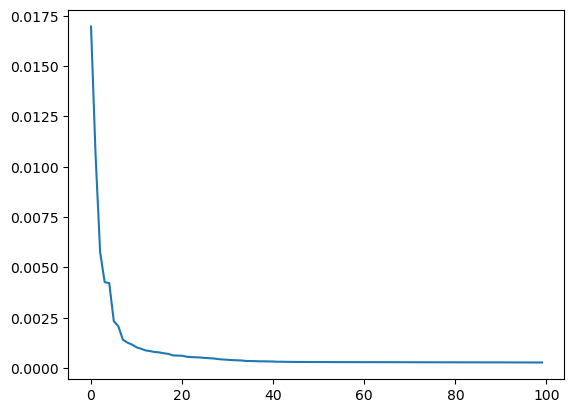

In [20]:
fig, ax = plt.subplots()
ax.plot(model.explained_variance_ratio_)

In [ ]:
# transform all other data
chunk_size = 50000
chunks = []
for chunk_start in range(0, adata_merge.shape[0], chunk_size):
    chunks.append(
        model.transform(adata_merge.X[chunk_start : (chunk_start + chunk_size)])
    )

# add NNZ PCs to adata
adata_merge.obsm["X_pca"] = np.concatenate(chunks, axis=0)[:, sel_dim]

# remove low variance PCs
n_pcs = significant_pc_test(adata_merge, p_cutoff=0.05, obsm="X_pca")

# scale PC by singular values
adata_merge.obsm["X_pca"] /= model.singular_values_[sel_dim][:n_pcs]

In [26]:
adata_merge.obs.loc[:,adata_merge.obs.dtypes=='object'] = adata_merge.obs.loc[:,adata_merge.obs.dtypes=='object'].values.astype(str)

In [28]:
for m in ["mC", "RNA"]:
    adata = adata_merge[adata_merge.obs["Modality"] == m]
    adata.write_h5ad(f"{m.lower()}_pca.h5ad")